# Исследование надёжности заёмщиков

Заказчик — кредитный отдел банка "Лучший банк". Нужно разобраться, влияет ли семейное положение и количество детей клиента на факт погашения кредита в срок. Входные данные от банка — статистика о платёжеспособности клиентов.

Результаты исследования будут учтены при построении модели **кредитного скоринга** — специальной системы, которая оценивает способность потенциального заёмщика вернуть кредит банку.

<br> Вопросы для исследования:
- "Есть ли зависимость между наличием детей и возвратом кредита в срок?";<br>
- "Есть ли зависимость между семейным положением и возвратом кредита в срок?";<br>
- "Есть ли зависимость между уровнем дохода и возвратом кредита в срок?";<br>
- "Как разные цели кредита влияют на его возврат в срок?"; <br><br>

### Шаг 1. Знакомство и обработка данных. 

In [1]:
import pandas as pd
import numpy as np

from pymystem3 import Mystem

import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
info_clients = pd.read_csv('data.csv')
info_clients.head()

,children,days_employed,dob_years,education,education_id,family_status,family_status_id,gender,income_type,debt,total_income,purpose
0,1,-8437.673028,42,высшее,0,женат / замужем,0,F,сотрудник,0,253875.639453,покупка жилья
1,1,-4024.803754,36,среднее,1,женат / замужем,0,F,сотрудник,0,112080.014102,приобретение автомобиля
2,0,-5623.422610,33,Среднее,1,женат / замужем,0,M,сотрудник,0,145885.952297,покупка жилья
3,3,-4124.747207,32,среднее,1,женат / замужем,0,M,сотрудник,0,267628.550329,дополнительное образование
4,0,340266.072047,53,среднее,1,гражданский брак,1,F,пенсионер,0,158616.077870,сыграть свадьбу


Столбцы содержат информацию:

- *children* — количество детей в семье
- *days_employed* — общий трудовой стаж в днях
- *dob_years* — возраст клиента в годах
- *education* — уровень образования клиента
- *education_id* — идентификатор уровня образования
- *family_status* — семейное положение
- *family_status_id* — идентификатор семейного положения
- *gender* — пол клиента
- *income_type* — тип занятости
- *debt* — имел ли задолженность по возврату кредитов
- *total_income* — ежемесячный доход
- *purpose* — цель получения кредита

In [3]:
info_clients.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21525 entries, 0 to 21524
Data columns (total 12 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   children          21525 non-null  int64  
 1   days_employed     19351 non-null  float64
 2   dob_years         21525 non-null  int64  
 3   education         21525 non-null  object 
 4   education_id      21525 non-null  int64  
 5   family_status     21525 non-null  object 
 6   family_status_id  21525 non-null  int64  
 7   gender            21525 non-null  object 
 8   income_type       21525 non-null  object 
 9   debt              21525 non-null  int64  
 10  total_income      19351 non-null  float64
 11  purpose           21525 non-null  object 
dtypes: float64(2), int64(5), object(5)
memory usage: 2.0+ MB


Мы видим, что в данных 21525 строк и 12 столбцов. В столбце с общим трудовым стажем в днях в ряде значений имеются пропуски, тоже самое мы наблюдаем в столбце с ежемесячным доходом. Можем предположить, что данные пропущены, так как человек никогда не работал и соответственно не имеет ежемесячного дохода. Удалим строки, в которых пропущены значения в столбцах с доходом и стажем.

In [4]:
info_clients = info_clients.dropna().reset_index(drop=True)

In [5]:
info_clients.describe(include=[np.number])

,children,days_employed,dob_years,education_id,family_status_id,debt,total_income
count,19351.000000,19351.000000,19351.000000,19351.000000,19351.000000,19351.000000,1.935100e+04
mean,0.537388,63046.497661,43.255336,0.819079,0.972249,0.081184,1.674223e+05
std,1.371408,140827.311974,12.579170,0.550104,1.420596,0.273125,1.029716e+05
min,-1.000000,-18388.949901,0.000000,0.000000,0.000000,0.000000,2.066726e+04
25%,0.000000,-2747.423625,33.000000,1.000000,0.000000,0.000000,1.030532e+05
50%,0.000000,-1203.369529,42.000000,1.000000,0.000000,0.000000,1.450179e+05
75%,1.000000,-291.095954,53.000000,1.000000,1.000000,0.000000,2.034351e+05
max,20.000000,401755.400475,75.000000,4.000000,4.000000,1.000000,2.265604e+06


Числовые характеристики наших данных.
<br> В столбце с детьми минимальное количество детей -1, что возможно говорит об ошибке в данных или о том, что заемщик терял ребенка. Максимальное значение детей равно 20.
<br> Минимальное количество дней стажа у нас представлено отрицательным значением, должно быть в данных ошибка. Ниже посмотрим какое количество строк, с отрицательными значениями в стаже. Макисмальное количество стажа в днях у заемщика равняется 401755, что говорит о невозможности такого значения и об ошибке, так как человек не может работать более 1000 лет.
<br> Минимальное количество лет заемщика равное значению 0, так же говорит об ошибке, очевидно, что заемщик должен быть старше 18 лет.

In [6]:
len(info_clients[info_clients['days_employed'] < 0])

15906

У нас 15906 строк с данными, где стаж представлен отрицательным значением, должно быть ошибка.

In [7]:
info_clients['days_employed'] = abs(info_clients['days_employed']).astype('int')
info_clients['total_income'] = info_clients['total_income'].astype('int')

Убрали отрицательный знак перед значениями и привели значения к целым числам. Значения в столбце с ежемесячным доходом так же приведем к целым числам.

In [8]:
len(info_clients[info_clients['dob_years'] == 0])

91

In [9]:
info_clients = info_clients[info_clients['dob_years'] != 0].reset_index(drop=True)

У нас в данных 91 заемщик с возрастом 0, скорее всего, заемщики не указывали свой возраст. Можем убрать этих заемщиков, чтобы они не влияли на наши данные.

In [10]:
info_clients.describe(include=[np.object])

,education,family_status,gender,income_type,purpose
count,19260,19260,19260,19260,19260
unique,15,5,3,8,38
top,среднее,женат / замужем,F,сотрудник,свадьба
freq,12290,11098,12688,9964,717


Категориальные характеристики данных.
<br> В столбце с образованием 15 различных категорий, чаще всего встречается образование "среднее", у 13750 заемщиков.
<br> В столбце с семейным статусом 5 различных категорий, чаще всего встречается образование "женат / замужем", у 12380 заемщиков.
<br> В столбце с полом 3 различных категории, чаще всего встречаются женщины, они составляют 14236 человек.
<br> В столбце с типом занятости 8 различных категорий, чаще всего встречается "сострудник", 11119 заемщиков.
<br> В столбце с целью кредита 38 различных категорий, чаще всего встречается заем на свадьбу, у 797 заемщиков.

### Шаг 2. Работаем с каждым столбцом по отдельности.

#### children

In [11]:
children = info_clients['children'].value_counts()
children

 0     12649
 1      4328
 2      1838
 3       293
 20       66
-1        44
 4        34
 5         8
Name: children, dtype: int64

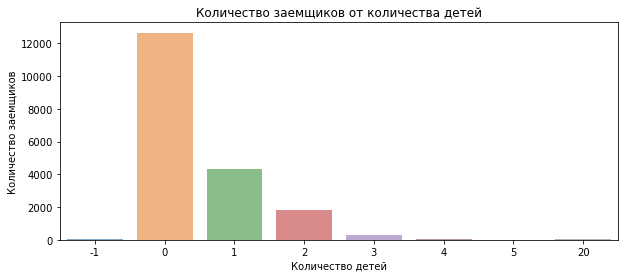

In [12]:
plt.figure(figsize=(10, 4))
sns.barplot(x=children.index, y=children.values, alpha=0.6)
plt.title('Количество заемщиков от количества детей')
plt.xlabel('Количество детей')
plt.ylabel('Количество заемщиков')
plt.show()

На графике видим, что большинство заемщиков не имеют детей. У чуть более 4000 заемщиков есть один ребенок, у 2000 замещиков два ребенка.

#### days_employed

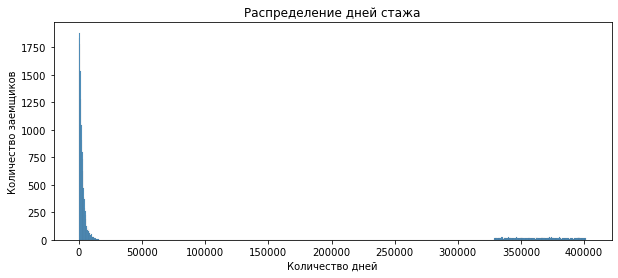

In [13]:
plt.figure(figsize=(10, 4))
plt.title('Распределение дней стажа')
sns.histplot(info_clients['days_employed'])
plt.xlabel('Количество дней')
plt.ylabel('Количество заемщиков')
plt.show()

На графике видим, что у нас есть значительные выбросы в количестве дней стажа на уровне 350000 дней. Человек не может проработать за свою жизнь столько дней.

In [14]:
info_clients = (info_clients[info_clients['days_employed'] < 20000]).reset_index(drop=True)

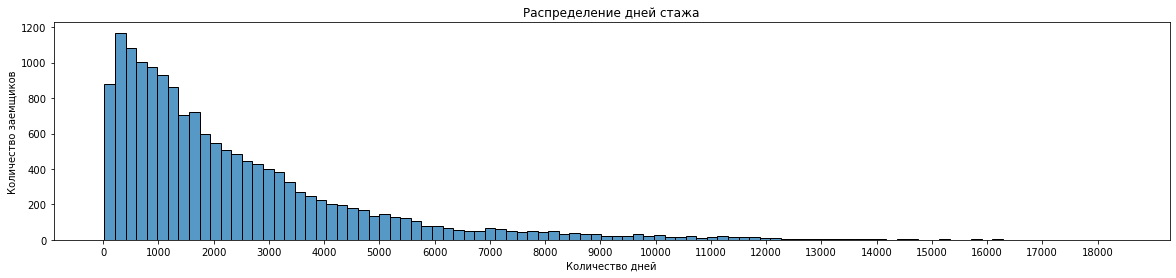

In [15]:
plt.figure(figsize=(20, 4))
plt.title('Распределение дней стажа')
sns.histplot(info_clients['days_employed'])
plt.xticks(np.arange(0, max(info_clients['days_employed']), 1000))
plt.xlabel('Количество дней')
plt.ylabel('Количество заемщиков')
plt.show()

Вот теперь мы видим, как распределены дни стажа у наших заемщиков. Можно отследить закономерность, что количество заемщиков уменьшается с ростом количества дней стажа.

In [16]:
info_clients_days_2000 = info_clients[info_clients['days_employed'] < 2000]

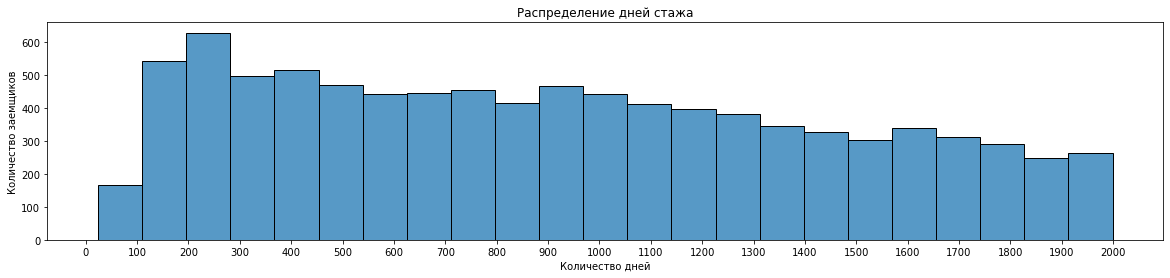

In [17]:
plt.figure(figsize=(20, 4))
plt.title('Распределение дней стажа')
sns.histplot(info_clients_days_2000['days_employed'])
plt.xticks(np.arange(0, 2100, 100))
plt.xlabel('Количество дней')
plt.ylabel('Количество заемщиков')
plt.show()

Если посмотреть детально на основную группу, видим, что у нас нет заемщиков, которые совсем не работали. Большинство заемщиков в наших данных работали от 200 до 300 дней.

#### dob_years

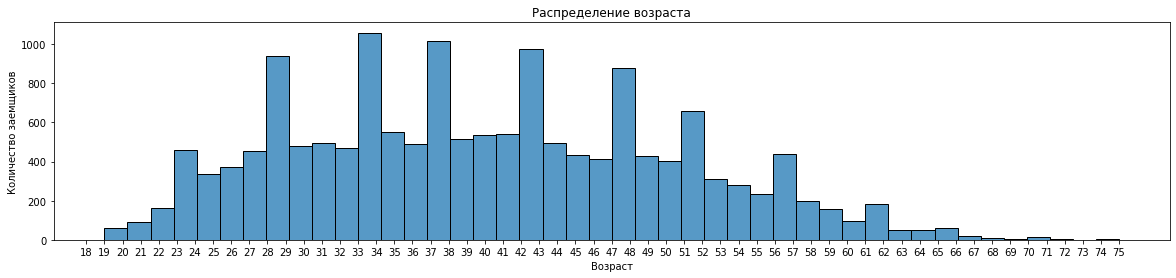

In [18]:
plt.figure(figsize=(20, 4))
plt.title('Распределение возраста')
sns.histplot(info_clients['dob_years'])
plt.xticks(np.arange(18, max(info_clients['dob_years']+1), 1))
plt.xlabel('Возраст')
plt.ylabel('Количество заемщиков')
plt.show()

На графике видим, что возраст заемщиков распределен неравномерно. Есть пики по количеству заемщиков опредленного возраста. Например, значительно выделются возраста: 28, 33, 37, 42, 47.

#### education

In [19]:
info_clients['education'].unique()

array(['высшее', 'среднее', 'Среднее', 'СРЕДНЕЕ', 'ВЫСШЕЕ',
       'неоконченное высшее', 'начальное', 'Высшее',
       'НЕОКОНЧЕННОЕ ВЫСШЕЕ', 'Неоконченное высшее', 'НАЧАЛЬНОЕ',
       'Начальное', 'УЧЕНАЯ СТЕПЕНЬ', 'ученая степень'], dtype=object)

Уникальные значения по типу образования имеют одни и те же категории, но заполненные капслоком.

In [20]:
info_clients['education'] = info_clients['education'].str.lower()
info_clients['education'].unique()

array(['высшее', 'среднее', 'неоконченное высшее', 'начальное',
       'ученая степень'], dtype=object)

Привели данные в строках к нижнему регистру.

In [21]:
education = info_clients['education'].value_counts()

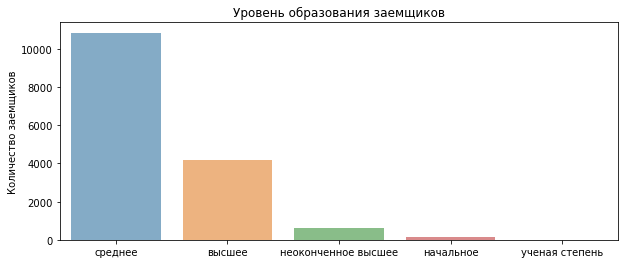

In [22]:
plt.figure(figsize=(10, 4))
sns.barplot(x=education.index, y=education.values, alpha=0.6)
plt.title('Уровень образования заемщиков')
plt.xlabel(None)
plt.ylabel('Количество заемщиков')
plt.show()

Большинство наших заемщиков со средним образованием.  Чуть больше 4000 заемщиков с высшим образованием. Меньше всего заемщиков с ученой степени.

In [23]:
len(info_clients[info_clients['education'] == 'ученая степень'])

4

С ученой степенью у нас всего 4 заемщика.

#### education_id

In [24]:
info_clients['education_id'].unique()

array([0, 1, 2, 3, 4], dtype=int64)

In [25]:
info_clients['education'][info_clients['education_id'] == 0].unique()

array(['высшее'], dtype=object)

In [26]:
info_clients['education'][info_clients['education_id'] == 1].unique()

array(['среднее'], dtype=object)

In [27]:
info_clients['education'][info_clients['education_id'] == 2].unique()

array(['неоконченное высшее'], dtype=object)

In [28]:
info_clients['education'][info_clients['education_id'] == 3].unique()

array(['начальное'], dtype=object)

In [29]:
info_clients['education'][info_clients['education_id'] == 4].unique()

array(['ученая степень'], dtype=object)

В столбце с идентификатором уровня образования все просто: 
<br> 0 - высшее
<br> 1 - среднее
<br> 2 - неоконченное высшее
<br> 3 - начальное
<br> 4 - ученая степень

#### family_status

In [30]:
family_status = info_clients['family_status'].value_counts()

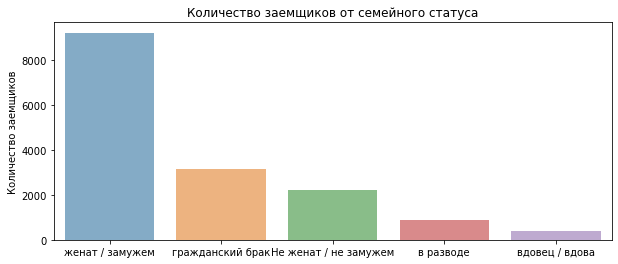

In [31]:
plt.figure(figsize=(10, 4))
sns.barplot(x=family_status.index, y=family_status.values, alpha=0.6)
plt.title('Количество заемщиков от семейного статуса')
plt.xlabel(None)
plt.ylabel('Количество заемщиков')
plt.show()

Большинство заемщиков женаты / замужем.

#### family_status_id

In [32]:
info_clients['family_status_id'].unique()

array([0, 1, 3, 4, 2], dtype=int64)

In [33]:
info_clients['family_status'][info_clients['family_status_id'] == 0].unique()

array(['женат / замужем'], dtype=object)

In [34]:
info_clients['family_status'][info_clients['family_status_id'] == 1].unique()

array(['гражданский брак'], dtype=object)

In [35]:
info_clients['family_status'][info_clients['family_status_id'] == 2].unique()

array(['вдовец / вдова'], dtype=object)

In [36]:
info_clients['family_status'][info_clients['family_status_id'] == 3].unique()

array(['в разводе'], dtype=object)

In [37]:
info_clients['family_status'][info_clients['family_status_id'] == 4].unique()

array(['Не женат / не замужем'], dtype=object)

В столбце с идентификатором семейного статуса: 
<br> 0 - женат / замужем
<br> 1 - гражданский брак
<br> 2 - вдовец / вдова
<br> 3 - в разводе
<br> 4 - не женат / не замужем

#### gender

In [38]:
gender = info_clients['gender'].value_counts()

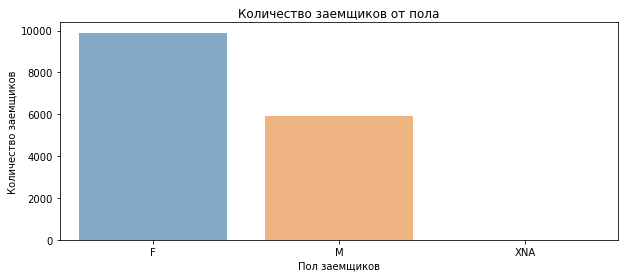

In [39]:
plt.figure(figsize=(10, 4))
sns.barplot(x=gender.index, y=gender.values, alpha=0.6)
plt.title('Количество заемщиков от пола')
plt.xlabel('Пол заемщиков')
plt.ylabel('Количество заемщиков')
plt.show()

Большинство наших заемщиков женщины. Есть категория пола, которая не определена.

In [40]:
len(info_clients[info_clients['gender'] == 'XNA'])

1

In [41]:
info_clients = info_clients[info_clients['gender'] != 'XNA'].reset_index(drop=True)

У нас одна строка с такой категорией. Удаляем.

#### income_type

In [42]:
income_type = info_clients['income_type'].value_counts()

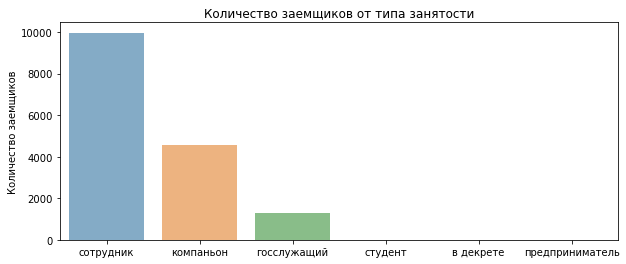

In [43]:
plt.figure(figsize=(10, 4))
sns.barplot(x=income_type.index, y=income_type.values, alpha=0.6)
plt.title('Количество заемщиков от типа занятости')
plt.xlabel(None)
plt.ylabel('Количество заемщиков')
plt.show()

Большинство заемщиков по типу данных "сотрудник".

In [44]:
len(info_clients[info_clients['income_type'] == 'в декрете'])

1

In [45]:
len(info_clients[info_clients['income_type'] == 'предприниматель'])

1

In [46]:
len(info_clients[info_clients['income_type'] == 'студент'])

1

В категориях типов занятости у нас по одному предпринимателю, студенту и заемщику в декрете.

In [47]:
info_clients.head()

,children,days_employed,dob_years,education,education_id,family_status,family_status_id,gender,income_type,debt,total_income,purpose
0,1,8437,42,высшее,0,женат / замужем,0,F,сотрудник,0,253875,покупка жилья
1,1,4024,36,среднее,1,женат / замужем,0,F,сотрудник,0,112080,приобретение автомобиля
2,0,5623,33,среднее,1,женат / замужем,0,M,сотрудник,0,145885,покупка жилья
3,3,4124,32,среднее,1,женат / замужем,0,M,сотрудник,0,267628,дополнительное образование
4,0,926,27,высшее,0,гражданский брак,1,M,компаньон,0,255763,покупка жилья


#### debt

In [48]:
debt = info_clients['debt'].value_counts()

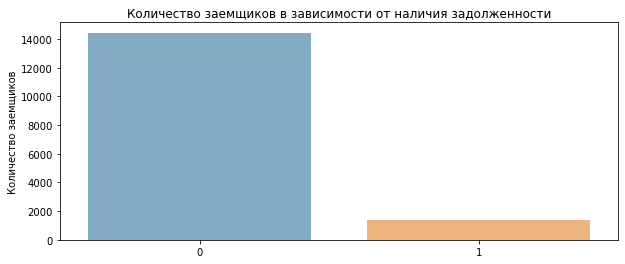

In [49]:
plt.figure(figsize=(10, 4))
sns.barplot(x=debt.index, y=debt.values, alpha=0.6)
plt.title('Количество заемщиков в зависимости от наличия задолженности')
plt.xlabel(None)
plt.ylabel('Количество заемщиков')
plt.show()

Большинство заемщиков выплатили кредит в срок(значение 0).

#### total_income

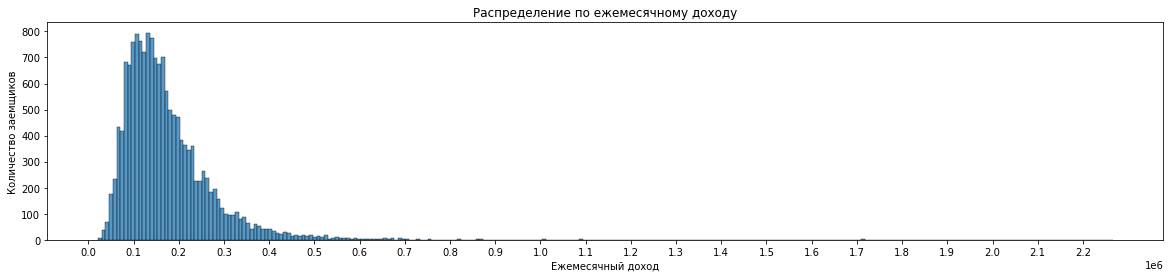

In [50]:
plt.figure(figsize=(20, 4))
plt.title('Распределение по ежемесячному доходу')
sns.histplot(info_clients['total_income'])
plt.xticks(np.arange(0, max(info_clients['total_income']), 100000))
plt.xlabel('Ежемесячный доход')
plt.ylabel('Количество заемщиков')
plt.show()

У нас есть доходы, которые сильно выбиваются из общего распределения, за счет этого график не выглядит достаточно информативным. Можно отметить что большинство заемщиков с ежемесяным доходом в границах от 50 до 150 тысяч.

In [51]:
dev = (info_clients['total_income'] - info_clients['total_income'].mean()).abs()
std = info_clients['total_income'].std()
info_clients['total_income'] = info_clients['total_income'][~(dev > 3 * std)].reset_index(drop=True)

Отфильтруем данные по правилу трех сигм, чтобы удалить сильно выбивающиеся значения.

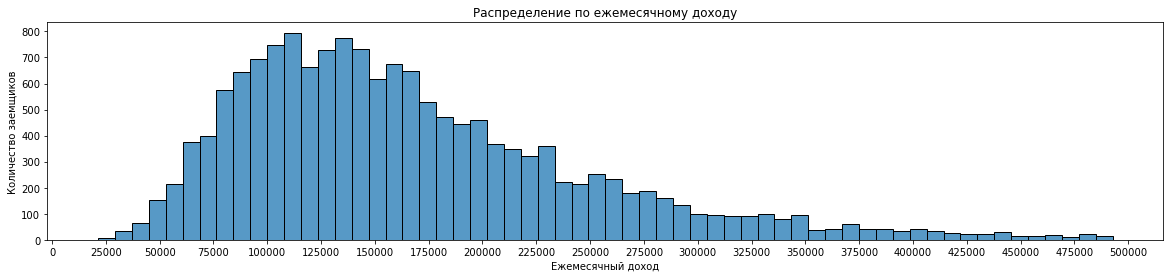

In [52]:
plt.figure(figsize=(20, 4))
plt.title('Распределение по ежемесячному доходу')
sns.histplot(info_clients['total_income'])
plt.xticks(np.arange(0, max(info_clients['total_income']+10000), 25000))
plt.xlabel('Ежемесячный доход')
plt.ylabel('Количество заемщиков')
plt.show()

После фильтрации данных мы можем увидеть, что больше всего заемщиков с ежемесячным доходом в диапазоне от 80 до 170 тысяч.

#### purpose

In [53]:
info_clients['purpose'].unique()

array(['покупка жилья', 'приобретение автомобиля',
       'дополнительное образование', 'операции с жильем', 'образование',
       'на проведение свадьбы', 'покупка жилья для семьи',
       'покупка недвижимости', 'покупка коммерческой недвижимости',
       'покупка жилой недвижимости',
       'строительство собственной недвижимости', 'недвижимость',
       'строительство недвижимости', 'на покупку своего автомобиля',
       'на покупку подержанного автомобиля', 'сыграть свадьбу', 'жилье',
       'операции со своей недвижимостью', 'автомобили',
       'заняться образованием', 'получение образования',
       'сделка с подержанным автомобилем', 'автомобиль', 'свадьба',
       'получение дополнительного образования', 'покупка своего жилья',
       'операции с недвижимостью', 'получение высшего образования',
       'операции с коммерческой недвижимостью', 'свой автомобиль',
       'сделка с автомобилем', 'профильное образование',
       'высшее образование', 'на покупку автомобиля',
      

В столбце с целями кредита есть много категорий, которые обозначают одно и то же, например, "покупка жилья" и "покупка недвижимости". Всего можно выделить 4 категории из всех уникальных значений: жилье, образование, свадьба, автомобиль.

In [55]:
m = Mystem()

In [56]:
def lem(purpose):
    lemmas = ''.join(m.lemmatize(purpose))
    #print(lemmas)
    return lemmas

Пишем функцию, которая лемматизирует все слова к начальной форме слова(лемме).

In [61]:
info_clients['purpose_group'] = info_clients['purpose'].apply(lem)
info_clients['purpose_group'].head(10)

0                 покупка жилье\n
1       приобретение автомобиль\n
2                 покупка жилье\n
3    дополнительный образование\n
4                 покупка жилье\n
5              операция с жилье\n
6                   образование\n
7         на проведение свадьба\n
8       покупка жилье для семья\n
9          покупка недвижимость\n
Name: purpose_group, dtype: object

In [62]:
def filtr(data):
    if 'жилье' in data or 'недвижимость' in data:
        return 'жилье'
    if 'образование' in data:
        return 'образование'
    if 'свадьба' in data:
        return 'свадьба'
    if 'автомобиль' in data:
        return 'авто'

In [63]:
info_clients['purpose_group'] = info_clients['purpose_group'].apply(filtr)
info_clients['purpose_group']

0              жилье
1               авто
2              жилье
3        образование
4              жилье
            ...     
15826          жилье
15827          жилье
15828          жилье
15829           авто
15830           авто
Name: purpose_group, Length: 15831, dtype: object

Фильтруем наши данные на 4 категории целей: жилье, образование, свадьба, авто.

In [64]:
purpose_group = info_clients['purpose_group'].value_counts()

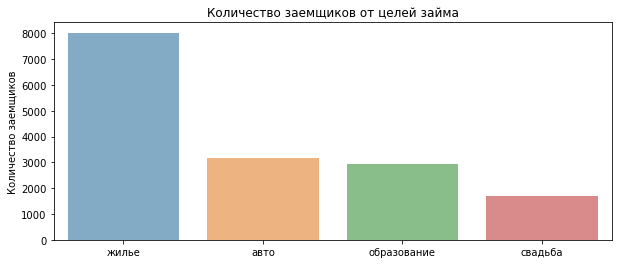

In [65]:
plt.figure(figsize=(10, 4))
sns.barplot(x=purpose_group.index, y=purpose_group.values, alpha=0.6)
plt.title('Количество заемщиков от целей займа')
plt.xlabel(None)
plt.ylabel('Количество заемщиков')
plt.show()

На графике видим, что большинство наших заемщиков оформляли ипотеку, порядка 8000 займов. Кредиты на авто и образование оформляли приблизительно по 3000 раз. Меньше всего кредитов с целью сыграть сводьбу, около 2000 раз.

### Шаг 3. Зависимости.

#### - Есть ли зависимость между наличием детей и возвратом кредита в срок?

In [68]:
def child(children):
    if children == 0:
        return 'нет детей'
    else:
        return 'дети есть'

In [69]:
info_clients['child_group'] = info_clients['children'].apply(child)
info_clients['child_group'].value_counts()

нет детей    9511
дети есть    6320
Name: child_group, dtype: int64

In [70]:
info_clients_children = info_clients.pivot_table(index='child_group', columns='debt', values='gender', aggfunc='count')
info_clients_children['percent'] = round(info_clients_children[1] / (info_clients_children[0] + info_clients_children[1])\
                                         * 100, 2)
info_clients_children.sort_values(by='percent', ascending=False)

debt,0,1,percent
child_group,,,
дети есть,5719,601,9.51
нет детей,8730,781,8.21


Из таблицы мы видим, что чаще всего не выплачивают кредит в срок заемщики, у которых есть дети, чем тем, у кого детей нет. То есть процент невозврата кредита в срок среди них больше, 9.51 %. Тогда как у заемщиков, у которых нет детей, проент невозврата ниже, 8.21 %.

#### - Есть ли зависимость между семейным положением и возвратом кредита в срок?

In [71]:
info_clients_family = info_clients.pivot_table(index='family_status', columns='debt', values='gender', aggfunc='count')
info_clients_family['percent'] = round(info_clients_family[1] / (info_clients_family[0] + info_clients_family[1]) * 100, 2)
info_clients_family.sort_values(by='percent',ascending=False)

debt,0,1,percent
family_status,,,
Не женат / не замужем,1960,241,10.95
гражданский брак,2831,308,9.81
женат / замужем,8489,744,8.06
в разводе,812,65,7.41
вдовец / вдова,357,24,6.30


Чаще всего не возвращают кредит в срок заемщики из категории "не женат / не замужем", процент невозврата среди них 10.95 %. Самый низкий процент невозврата, 6.3 %, у заемщиков в категории "вдовец / вдова".

#### - Есть ли зависимость между уровнем дохода и возвратом кредита в срок?

In [72]:
info_clients['total_income'].describe()

count     15616.000000
mean     166842.548476
std       80895.819772
min       21367.000000
25%      107778.750000
50%      149770.000000
75%      207197.250000
max      492776.000000
Name: total_income, dtype: float64

In [73]:
def total(total_income):
    if total_income <= 107778:
        return 'низкий'
    if total_income <= 149770:
        return 'ниже среднего'
    if total_income <= 207197:
        return 'выше среднего'
    else:
        return 'высокий'
    

Проведем категоризацию столбца с ежемесячным доходом на четыре категории по процентилям.

In [74]:
info_clients['income'] = info_clients['total_income'].apply(total)
info_clients['income'].value_counts()

высокий          4119
низкий           3904
ниже среднего    3904
выше среднего    3904
Name: income, dtype: int64

Получили 4 категории ежемесячного дохода: низкий, ниже среднего, выше среднего, высокий. Данные распределены приблизительно поровну. Больше всего заемщиков с высоким уровнем дохода.

In [75]:
info_clients_income = info_clients.pivot_table(index='income', columns='debt', values='gender', aggfunc='count')
info_clients_income['percent'] = round(info_clients_income[1] / (info_clients_income[0] + info_clients_income[1]) * 100, 2)
info_clients_income.sort_values(by='percent', ascending=False)

debt,0,1,percent
income,,,
выше среднего,3533,371,9.50
низкий,3568,336,8.61
ниже среднего,3570,334,8.56
высокий,3778,341,8.28


Самые неадежные заемщики оказались с доходом в категории "выше среднего", процент невозврата кредита в срок среди них 9.5 %. Это заемщики с доходом в диапазоне от 149770 до 207197. Чаще возвращают кредит в срок заемщики с самым высоким уровнем дохода, от 207197. Среди них процент невыплат 8.28 %.

#### - Как разные цели кредита влияют на его возврат в срок?

In [76]:
info_clients_purpose = info_clients.pivot_table(index='purpose_group', columns='debt', values='gender', aggfunc='count')
info_clients_purpose['percent'] = round(info_clients_purpose[1] / (info_clients_purpose[0] + info_clients_purpose[1]) * 100, 2)
info_clients_purpose.sort_values(by='percent', ascending=False)

debt,0,1,percent
purpose_group,,,
авто,2841,322,10.18
образование,2642,289,9.86
свадьба,1576,137,8.00
жилье,7390,634,7.90


Больше всего невыплат по кредиту у заемщиков, которые оформляли кредит на авто, 10.18 % из них не выплатили свой кредит в срок. Самые ответственные оказались заемщики, которые оформляли ипотеку. Среди них процент невыплат составил меньше всего, 7.9 %.

### Шаг 4. Общий вывод

   Исследование данных о платёжеспособности клиентов показало нам, что клиенты, у которых нет детей (процент невыплат 8.21), клиенты с высоким доходом от 207 197 рублей (процент невыплат 8.28), клиенты, которые оформляют заем на итпотеку (процент невыплат 7.9), а так же вдовцы или вдовы (процент невыплат 6.3) имеют более высокий уровень платежеспособности.

<br> И самые ненадежные клиенты с точки зрения платёжеспособности, клиенты, у которых есть дети (процент невыплат 9.51), клиенты с доходом от 149 770 до 207 197 рублей (процент невыплат 9.5), a клиенты, которые оформлляют кредит на покупку автомобиля (процент невыплат 10.18) или клиенты, не состоящие ни в каких отношениях (процент невыплат 10.95) имеют самый большой процент просрочек.

<br> Таким образом, мы исследовали клиентов и обнаружили зависимости различных факторов, которые могут влиять на выплату кредита в срок. Результаты исследования будут учтены при построении модели кредитного скоринга — специальной системы, которая оценивает способность потенциального заёмщика вернуть кредит банку.